In [ ]:
#| hide

from dynbps.BPS import *
from dynbps.loadData import loadDataInf
import numpy as np
import pandas as pd
import openpyxl
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
from numpy import linspace

/var/folders/bb/0rhpzdwj47d2gfk1dmgsvv6w0000gn/T/ipykernel_17765/969484469.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


# dynbps

> Python code for Dynamic BPS

## Install

```sh
pip install dynbps
```

## Background

### Base Level Oveview

Bayesian Predictive Synthesis (BPS) is an ensemble method designed to aggregate and synthesize density predictions from multiple agents/experts/judges. There is quite a wide field of literature for ensembling point forecasts, but point forecasts are very limited because they do not convey uncertainty. The shape and variance of a distribution is equally important as the mean. Therefore, consider soliciting density predictions from $J$ judges. Each judge, $j = 1,...,J$ gives a density  $h_j(\cdot)$. The set of these predictions is $H = \{h_1(\cdot), ... , h_J(\cdot)\}$. We would like to predict an outcome $y$, given this information $H$. Typically, in Bayesian analysis, we would find the posterior $p(y|H)$ and be done with it. However, the posterior is found via $p(y|H) \propto p(H|y)p(y)$, and $p(H|y)$ is either impossible to find or necessitates significant modeling assumptions, making the value highly subjective. 

If we introduce a latent variable $\vec{x}$, then we can write the posterior as $$p(y|H) = \int_{\vec{x}}p(y|\vec{x}, H)p(\vec{x}|H)d\vec{x}$$

We can also assume $(y|\vec{x}) \perp H$, simplifying the posterior $$p(y|H) = \int_{\vec{x}}p(y|\vec{x})p(\vec{x}|H)d\vec{x}$$

Let's say that the latent variable $\vec{x}$ is a J-dimensional random variable from $\vec{x}\sim p(\vec{x}|H)$. The next question is how to we get $\vec{x} \sim p(\vec{x}|H)$? Quite simply, we can say these latent variables are "generated independently from the $h_j$", that is $x_j \sim h_j(\cdot)$ for $j=1:J$, and then $\vec{x} = (x_1,..., x_J)$. Due to independence of the random draws, we can write: $$p(y|H) = \int_{\vec{x}}p(y|\vec{x})\prod_{j=1:J} h_j(x_j) d\vec{x}$$

Now, how do we formulate $p(y|\vec{x})$? It's actually not too complicated! We are given covariates $\vec{x}$, and asked to predict an outcome $y$. Therefore, we can use tools that we are all familiar with, such as a linear regression. One of the nice things about BPS is that this conditional density $p(y|\vec{x})$, or "synthesis function", is not set in stone. There are limitless choices, and you can use your favorite method in this role. In traditional BPS literature, we use the symbol $\alpha(y|\vec{x})$ to represent this synthesis function. 


### Dynamic BPS

This package implements a dynamic version of BPS. The synthesis function follows a dynamic linear model (Prado and West Chapter 4). A dynamic linear model (DLM) predicts a time series outcome $y_t$ for $t=1:T$, and can be described by a pair of equations. First there is an observation equation:
$$y_t = \vec{F}_t\vec{\theta}_t + \nu_t$$ 
In the observation equation, $\vec{F}_t$ is the covariate vector. This vector is known and contains all the predictors. In BPS, an example is $\vec{F}_t = (1, x_{1,t}, x_{2,t}, ..., x_{J,t})$, where $x_{j,t}$ is a latent draw from Judge j's prediction at time t, and 1 is a constant that allows for an intercept term. The $\vec{\theta}_t$ are unobserved states, which act as the coefficients to the covariates in $\vec{F}_t$. Finally, $\nu_t$ is the measurement noise. The coefficients, $\vec{\theta}_t$, evolve via a second equation:
$$\vec{\theta}_t = G_t\vec{\theta}_{t-1} + \vec{w}_t  $$

$G_t$ is called the state evolution matrix, and $\vec{w}_t$ is noise in this process. In this implementation, $G_t =I$, and the states evolve via a random walk. 

This pair of equations describes the DLM that is our aforementioned synthesis function, which now varies through time $\alpha_t(y_t|\vec{x}_t)$

Going through time, the math behind dynamic BPS is quite involved. An arxiv of the orginal paper by McAlinn and West can be found at https://arxiv.org/abs/1601.07463. In broad strokes, BPS works by sampling latent states from the posterior given by the DLM, and then builds the DLM using these states and continues to alternate between sampling and building for the pre-specified number of MCMC iterations. This back and fourth is closely related to the Forward Filter Backwards Smoothing algorithm (Prado and West Chapter 4), and allows BPS to correct for agent biases, codependencies, and mispecifications 


## How to use

There are three steps to using this method. First, create an object using the training information. Second, use the .fit() method to fit the model to the training data. Finally, use the .predict() method, which takes the new agent means, variances, and degrees of freedom as arguments, to predict the outcome at time T+1. Inflation forecasting data, originally provided at https://www2.stat.duke.edu/~mw/mwsoftware/BPS/index.html, is made available through the dynbps package, and is used in this example

### Step 0: Read in the data and set priors

In [ ]:
yI, a, A, n = loadDataInf()
T = yI.shape[0] # total time in analysis
J = a.shape[1] # number of agents
p = J + 1 # number of agents plus intercept
# set priors
delta = [0.95, 0.99] # discount factors 
m_0 = np.ones(shape = [J + 1])/J # prior mean for agent coefficients 
m_0[0] = 0 # prior mean for intercept
C_0 = np.eye(p) * 1 # prior for covariance matrix
n_0 = 1/(1 - delta[1]) # prior on BPS degrees of freedom
s_0 = 0.01 # prior on BPS observation variance 
burn_in, mcmc_iter = 2000, 3000 


### Step 1: Create a BPS object

When creating the BPS object, I provide all inputs. The user must specify the first three inputs: target series, agent means, and agent variances. If the degrees of freedom are not given, they default to 30, effectively implementing a normal distribution instead of a t-distribution. The default entries for all other parameters are equal to their respective values in the code above. 

In [ ]:
## Remove the last observation to prevent data leak
yT = yI[0:-1]
aT = a[0:-1,]
AT = A[0:-1,]
nT = n[0:-1,]
model = BPS(yT,aT,AT,nT,delta,m_0,C_0,n_0,s_0,burn_in,mcmc_iter)

### Step 2: Fit the model 

Now that the object is created, we can fit the model using the .fit() method. The .fit() method will print out the current MCMC iteration every 1000 iterations. The total number of iterations is burn_in + mcmc_iter = 5000. This process may take a few minutes. 

In [ ]:
model.fit()

0
1000
2000
3000
4000


### Step 3: Predict the next outcome

Finally, feed the new agent means $a$, variances $A$, and degrees of freedom $n$ into the .predict() method to get a predicted mean and variance for $y_{T+1}$. 

In [ ]:
a_new = a[-1,]
A_new = A[-1,]
n_new = n[-1,]
answer = model.predict(a_new, A_new, n_new)
predicted_mean = answer[0]
predicted_variance = answer[1]

print(predicted_mean)
print(predicted_variance)

1.5999742312322198
0.01667075932173112


## Motivating Example

When combining predictive densities, most ensemble methods are linear combinations of the densities themselves. 

$$f(X|A_{1:J}) = \sum_{j=1:J} w_j h_j(X)$$

The most prominent example is Bayesian Model Averaging (BMA), where the weights are the posterior probability of the model (or agent), given the data $D$

$$w_k = P(A_k|D) = \frac{P(D|A_k)P(A_k)}{\sum_{j=1:J} P(D|A_j)P(A_j)}$$

This linear combination of the densities is intuitive and useful, but it is ultimately underparametrized. When the agents are correlated and/or misspecified, the linear combination of the densities struggles. In many cases, linear combination methods converge to one singular model (the one that has performed best so far), throwing away the potential information in the correlation structure of the agent predictions. Furthermore, in the likely situation where the forecasting problem is "$M-open$", (none of the models are correct) the underparamterization of the ensemble is exacerbated. 

In this section, I present a simple motivating example that I hope will educate the reader on latent synthesis, and bolster their understanding of BPS. This example is in the "$M-open$" setting, where all agents are incorrected. The agents are not correlated, and are constant through time. These simplifications are intentional, and are designed to highlight the advantages of latent synthesis. I want to acknowledge that there are many examples where BMA and other linear density combinations have been used to great success. However, this example highlights a weakness in linear combination, one that we should not ignore in more complicated applications.  


Consider the following data generating process 

$$Y = 0.5*X_1 + 0.5*X_2$$ 

where $X_1$ and $X_2$ are unobserved variables that are correlated via a bivariate normal distribution 

$$\begin{pmatrix}
X_1 \\ X_2 \end{pmatrix}\sim N\bigg(\begin{pmatrix}
1 \\
4
\end{pmatrix},\begin{pmatrix}
1 & 0.5\\
0.5 & 1
\end{pmatrix}\bigg)$$

Assume that there are 100 observations of $Y$ and  a decision maker wants to use two agents in an ensemble. Agent 1 always submits density forecast $h_1(\cdot) := N(1,1)$, and Agent 2 always submits $h_2(\cdot):=N(4,1)$. The agents struggle at predicting $Y$, but they perfectly describe the marginal distributions of $X_1$, and $X_2$. Therefore, the decision maker has all the necessary information to create a reasonable ensemble forecast for $Y$. 

In [ ]:
#### Code for Generating Y
p = 2
n = 100
means = [1,4]
vars = [1,1]
Sigma = np.matrix([[vars[0],0.5],[0.5,vars[1]]])
X = np.random.multivariate_normal(means, Sigma, n).T

Y = 0.5*X[0] + 0.5*X[1]

### Calculating True Distribution of Y
transform = np.matrix([0.5,0.5])
mu_true = np.matmul(transform, means)
var_true = np.matmul(np.matmul(transform, Sigma), transform.T)
sd_true = np.sqrt(var_true)




Below, I create a plot that shows the true density of $Y$ (black), the observed density of $Y$ (gray), and the predicted densities from the agents (green). In light red, I show the range of possible results from a linear ensemble of the agent densities, when weights are restricted to the unit simplex. It is important to note that the unit simplex includes $(w_1, w_2) = (1,0)$ and $(w_1, w_2)= (0,1)$, where the ensemble converges to one of the agents. 

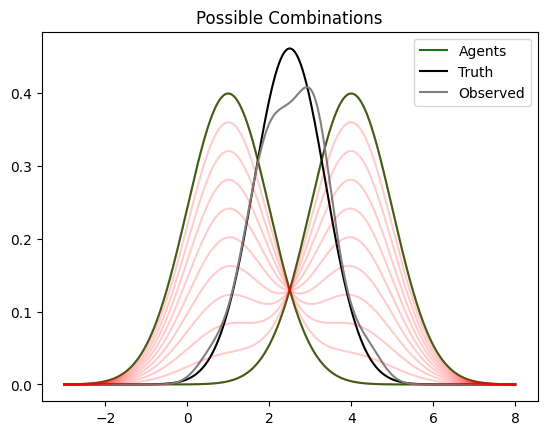

In [ ]:
dist_space = linspace( -3, 8, 1000 ) ## For evaluation of the KDE for Y


plt.plot(dist_space, norm.pdf(dist_space, loc = means[0], scale = 1), color = "darkgreen", alpha = 0.9, label = "Agents")
plt.plot(dist_space, norm.pdf(dist_space, loc = means[1], scale = 1), color = "darkgreen", alpha = 0.9)
plt.plot(dist_space, norm.pdf(dist_space, loc = mu_true, scale =sd_true)[0], color = "black", label = "Truth")
plt.plot(dist_space, gaussian_kde(Y)(dist_space), color = "gray", label = "Observed")
for j in range(0,11):
  plt.plot(dist_space, (j/10)*norm.pdf(dist_space, loc = means[0], scale = 1) + ((10-j)/10)*norm.pdf(dist_space, loc = means[1], scale = 1), color = "red", alpha = .2)
plt.title("Possible Combinations")
plt.legend()
plt.show()

From this plot, it is clear that no linear combination of densities with weights on the unit simplex will give a satisfactory result. In fact, no linear combination, even without restriction on weights, will capture the distribution of $Y$. Writing $h_Y$ in terms of $h_1$ and $h_2$ is complicated and requires an interaction term $h_1(x)*h_2(x)$. Furthermore, while adding interaction terms is possible in this simple example it quickly becomes infeasible when $J$ becomes large, and does not provide guarantees when the DGP is more complicated. 

Latent ensemble models such as BPS take latent draws from $H = (h_1,h_2)$ to get $(\hat{x}_1, \hat{x_2})$. Then, using the latent draws, BPS will predict $Y$ through the synthesis function. Therefore, while latent synthesis sounds intimidating, and its strong performance makes people assume it is complex, the underlying motivation is quite intuitive. Combining densities directly creates an inflexible ensemble. Combining latent draws from a distribution helps combat misspecification and codependencies between agents. 

0


<matplotlib.legend.Legend>

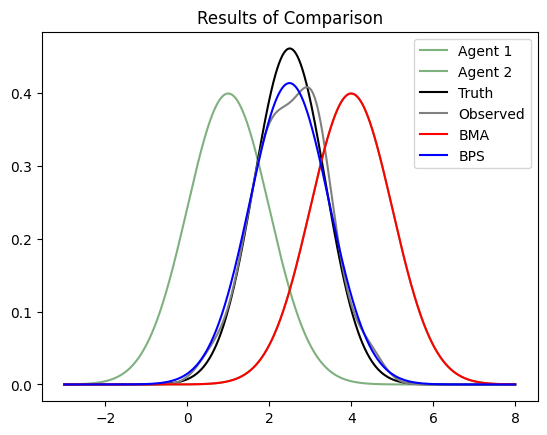

In [ ]:
## Code Updating Plot with BPS and BMA


### BMA: Find Posterior Model Probabilities 
M1L = sum(np.log(norm.pdf(Y, loc = means[0], scale = 1)))
M2L = sum(np.log(norm.pdf(Y, loc = means[1], scale = 1)))
w1 = np.exp(M1L)/(np.exp(M1L) + np.exp(M2L))
w2 = np.exp(M2L)/(np.exp(M1L) + np.exp(M2L))


a = np.tile(np.array(means), (100, 1)) ## Create input mean array for BPS
A = np.tile(np.array(vars),(100,1)) ## Create input variance array for BPS

model = BPS(y=Y[:-1,], a_j=a[:-1,], A_j = A[:-1,], s_0 = 1, mcmc_iter = 500, burn_in = 500)
model.fit()
bps_mean, bps_var = model.predict(a[-1,], A[-1,])



plt.plot(dist_space, norm.pdf(dist_space, loc = means[0], scale = 1), color = "darkgreen", alpha = 0.5, label = "Agent 1")
plt.plot(dist_space, norm.pdf(dist_space, loc = means[1], scale = 1), color = "darkgreen", alpha = 0.5, label = "Agent 2")
plt.plot(dist_space, norm.pdf(dist_space, loc = mu_true, scale =sd_true)[0], color = "black", label = "Truth")
plt.plot(dist_space, gaussian_kde(Y)(dist_space), color = "gray", label = "Observed")
plt.plot(dist_space, w1*norm.pdf(dist_space, loc = means[0], scale = 1) + (w2)*norm.pdf(dist_space, loc = means[1], scale = 1), color = "red", label = "BMA")
plt.plot(dist_space, norm.pdf(dist_space, loc = bps_mean, scale =np.sqrt(bps_var)), color = "blue", label = "BPS")
plt.title("Results of Comparison")
plt.legend()

We see above that BMA converges to one of our mispecified agents. On the other hand, BPS is able to overcome the agent mispecification and give an accurate distribution for $Y$.

Linear density combinations can give great results, but they are underparametrized, and struggle when agents are mispecified or codependent. Mispecification and codependencies are almost certain in real world applications, and latent synthesis methods, such as BPS, are among the best tools for the job. 


## Acknowledgements

I would like to acknowledge the efforts of Srikar Katta in creating the inital draft of python code for BPS. He gratiously shared his code with me - giving me a strong launching point. Srikar is now studying for his PhD at Duke University. His webpage is located at https://scholars.duke.edu/person/srikar.katta/academic-experience. Thank you Srikar!